# Analysis DA-Approach

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_auc_histograms(file_paths: dict, bins: int = 100, cols: int = 3, figsize_per_row: int = 5):
    """
    Generates histograms illustrating the distribution of predicted AUC values.

    Parameters:
    - file_paths (dict): Dictionary with label as key and path to CSV file as value
    - bins (int): Number of bins in the histogram
    - cols (int): Number of columns in the subplot grid
    - figsize_per_row (int): Height per plot row in the figure layout

    """
    # Import data
    data_dict = {}
    for label, path in file_paths.items():
        df = pd.read_csv(path, index_col=0)
        # create an one-dimensional array (1D)
        data_dict[label] = df.values.flatten()

    # Layout (How many graphics next to each other)
    num_plots = len(data_dict)
    rows = (num_plots + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, figsize_per_row * rows))
    axes = axes.flatten()

    # several histograms side by side, one for each model with marked mean value 
    for i, (label, values) in enumerate(data_dict.items()):
        axes[i].hist(values, bins=bins, color='skyblue', edgecolor='black')
        mean_val = np.mean(values)
        axes[i].axvline(x=mean_val, color='red', linestyle='--', linewidth=2,
                        label=f'Mittelwert = {mean_val:.2f}')
        axes[i].set_xlabel('AUC-Wert')
        axes[i].set_ylabel('Häufigkeit')
        axes[i].set_title(label)
        axes[i].legend()

    # Hide empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_model_vs_gdsc_scatter(file_paths: dict, gdsc_path: str, cols: int = 3, figsize_per_row: int = 6):
    """
    Generates scatterplots of the mean AUC values per drug of a model compared to the GDSC dataset.

     Parameters:
    - file_paths (dict): Mapping of model names to CSV file paths with AUC values (Drugs in Columns)
    - gdsc_path (str): Path to GDSC reference file (.csv or .zip) containing AUCs for all drugs
    - cols (int): Number of columns in the subplot grid
    - figsize_per_row (int): Height of each row in the figure
    """

    # Load GDSC data and calculate mean values
    gdsc_dataset = pd.read_csv(gdsc_path, index_col=0)
    gdsc_drugs = gdsc_dataset.iloc[:, -200:]
    means_gdsc = gdsc_drugs.mean()

    # Calculate model mean values per drug
    model_means = {
        label: pd.read_csv(path, index_col=0).mean(axis=0)
        for label, path in file_paths.items()
    }

    # Determine common drugs (200)
    common_drugs_dict = {
        label: model_mean.index.intersection(means_gdsc.index)
        for label, model_mean in model_means.items()
    }

    # Prepare plot grid
    num_models = len(model_means)
    rows = (num_models + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, rows * figsize_per_row))
    axes = axes.flatten()

    # Create scatterplots
    for i, (label, means_model) in enumerate(model_means.items()):
        common_drugs = common_drugs_dict[label]
        x = means_model[common_drugs]
        y = means_gdsc[common_drugs]

        print(f"{label}: {len(x)} Punkte im Plot") 

        axes[i].scatter(x, y, alpha=0.6)
        min_val = min(x.min(), y.min())
        max_val = max(x.max(), y.max())
        axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', label='Identitätslinie (y=x)')
        axes[i].set_title(f'{label} vs GDSC')
        axes[i].set_xlabel('AUC vom Modell')
        axes[i].set_ylabel('AUC von GDSC')
        axes[i].legend()
        axes[i].grid(True)

    # Hide empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


In [4]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

def spearman_pdx_vs_models_plot(pdx_path: str, file_paths: dict, drugs_pdx_slice: int = 12, figsize=(14,6), ylim=(-0.3, 1.0)):
    """
    Calculates Spearman correlations between PDX data and model predictions per drug and plots them as a scatterplot

    Parameter:
    - pdx_path: Path to the PDX file
    - file_paths: Dict with model names as keys and CSV paths as values
    - drugs_pdx_slice: Number of shared drugs between PDX and GDSC (default=12)
    - figsize: Size of the figure (default=(14,6))
    - ylim: y-axis range (default=(-0.3, 1.0))
    """
    # Load PDX Data
    pdx_dataset = pd.read_csv(pdx_path, index_col=0)
    drugs_pdx = pdx_dataset.iloc[:, -drugs_pdx_slice:]

    # Load models and filter same index 
    model_data = {}
    common_index = drugs_pdx.index

    for label, path in file_paths.items():
        df = pd.read_csv(path, index_col=0)
        model_data[label] = df
        common_index = common_index.intersection(df.index)

    # keep same index
    drugs_pdx_common = drugs_pdx.loc[common_index]
    model_data_common = {label: df.loc[common_index] for label, df in model_data.items()}

    # Calculate Spearman-Correlation
    # --- 3. Für jedes Modell separat arbeiten ---
    results = {label: {} for label in file_paths.keys()}
    for label, path in file_paths.items():
        # Lade Vorhersagen des aktuellen Modells
        df_pred = pd.read_csv(path, index_col=0)

        # Finde übereinstimmende Indizes mit PDX-Daten
        common_index = drugs_pdx.index.intersection(df_pred.index)

        if len(common_index) < 1:
            # Keine gemeinsamen Indizes -> alles NaN
            for drug in drugs_pdx.columns:
                results[label][drug] = float('nan')
            continue

        # Hole die relevanten PDX- und Vorhersagewerte
        drugs_pdx_common = drugs_pdx.loc[common_index]
        df_pred_common = df_pred.loc[common_index]

        # Berechne Spearman-Korrelation pro Drug
        for drug in drugs_pdx_common.columns:
            y_true = drugs_pdx_common[drug]
            y_pred = df_pred_common[drug]

            valid_idx = (~y_true.isna()) & (~y_pred.isna())
            y_true_valid = y_true[valid_idx]
            y_pred_valid = y_pred[valid_idx]

            if len(y_true_valid) < 5:
                results[label][drug] = float('nan')
            elif y_true_valid.nunique() < 2 or y_pred_valid.nunique() < 2:
                results[label][drug] = float('nan')
            elif np.std(y_true_valid) < 1e-6 or np.std(y_pred_valid) < 1e-6:
                results[label][drug] = float('nan')
            else:
                corr, _ = spearmanr(y_true_valid, y_pred_valid)
                results[label][drug] = corr

    # --- 4. In DataFrame konvertieren ---
    results_df = pd.DataFrame(results)

    # Prepare data for plot 
    results_melted = results_df.reset_index().melt(id_vars='index',
                                                   var_name='Methode',
                                                   value_name='Spearman-Korrelation')
    results_melted.rename(columns={'index': 'Drug'}, inplace=True)
    method_order = list(file_paths.keys())

    # Sorting by mean value (for better readability)
    drug_order = results_df.mean(axis=1).sort_values().index.tolist()

    # Create Plot
    plt.figure(figsize=figsize)

    for drug in drug_order:
        subset = results_melted[results_melted['Drug'] == drug]
        x_pos = [drug] * len(subset)
        y_vals = subset['Spearman-Korrelation'].values
        methods = subset['Methode'].values

        if len(y_vals) > 1:
            plt.plot([drug, drug], [np.min(y_vals), np.max(y_vals)],
                     color='gray', linewidth=1, alpha=0.5, zorder=1)

        sns.scatterplot(x=x_pos,
                        y=y_vals,
                        hue=methods,
                        palette='Set2',
                        s=80,
                        edgecolor='black',
                        legend=False,
                        zorder=2)

    plt.axhline(0, color='red', linestyle='-', linewidth=1)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Spearman-Korrelation (Zelllinie vs. PDX)')
    plt.xlabel('Medikament')
    plt.ylim(ylim)
    plt.title('Vergleich der Spearman-Korrelationen pro Medikament und Methode', fontsize=14)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)

    # Create legend manually (for consistent colors)
    method_colors = sns.color_palette('Set2', n_colors=10)
    custom_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor=method_colors[i],
                           markersize=10, markeredgecolor='black')
                    for i in range(len(method_order))]
    plt.legend(custom_lines, method_order, title='Methode',
               bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


# Figure ...

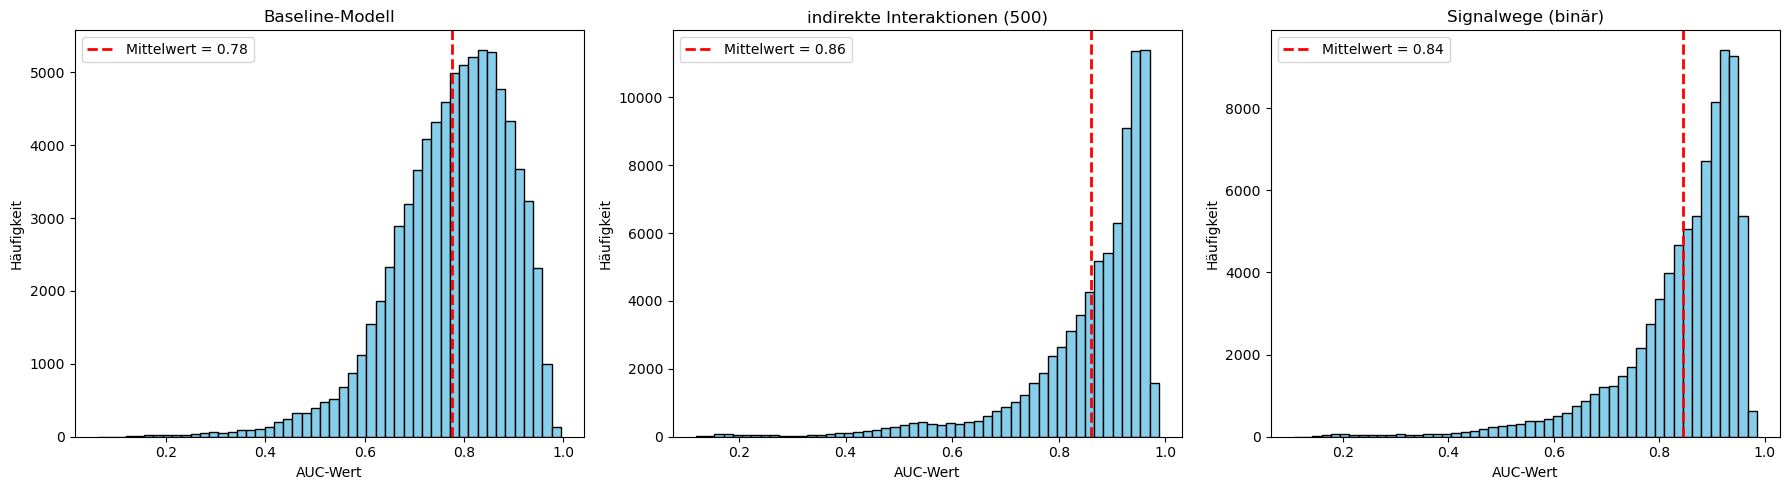

Baseline-Modell: 200 Punkte im Plot
indirekte Interaktionen (500): 200 Punkte im Plot
Signalwege (binär): 200 Punkte im Plot


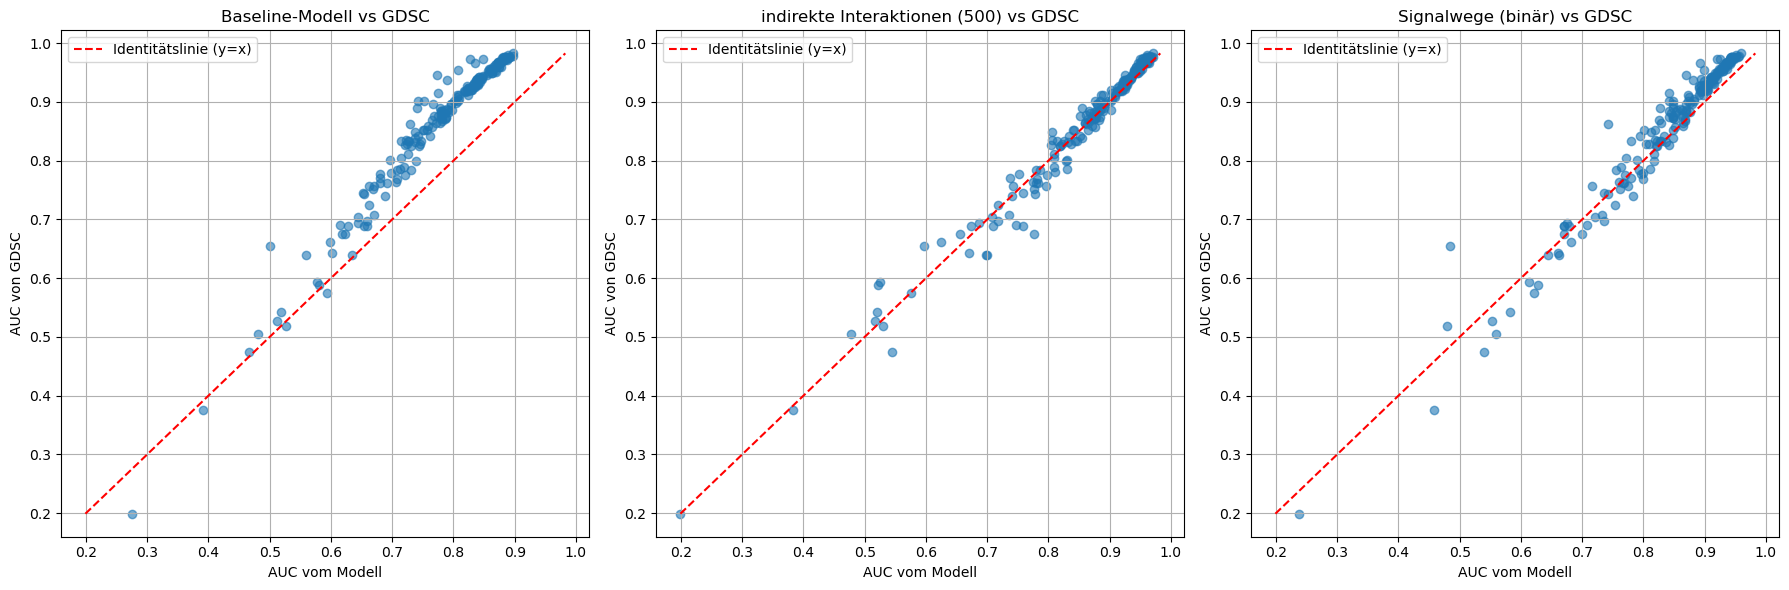

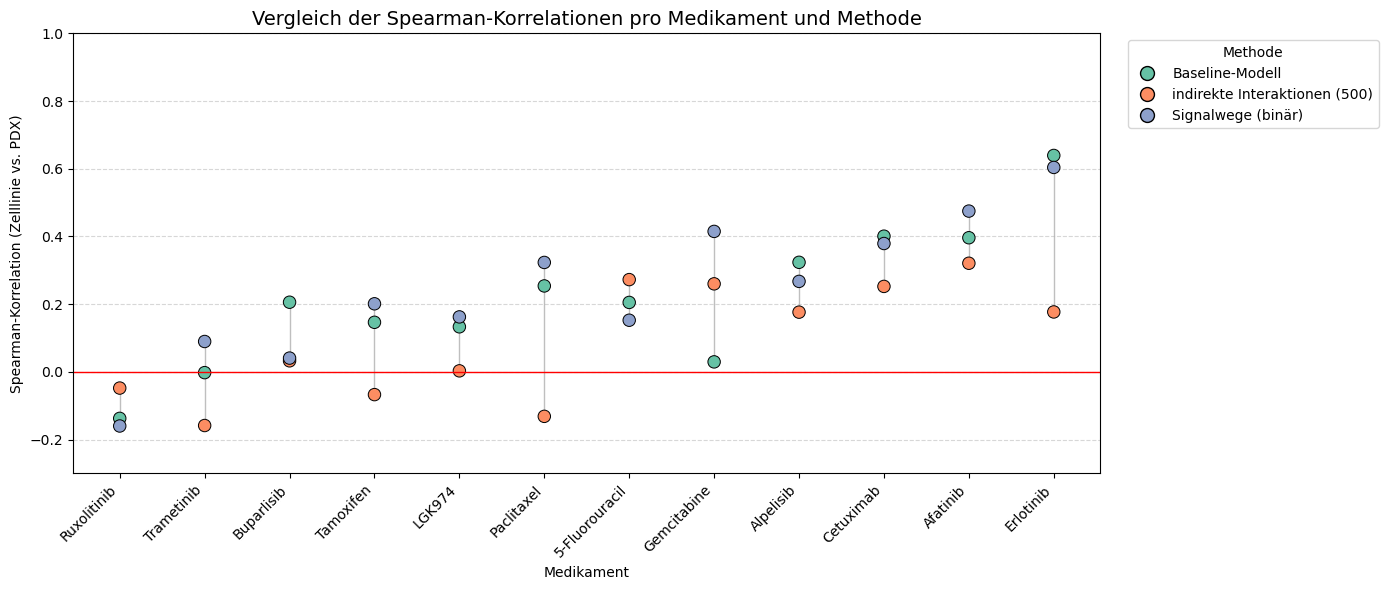

In [5]:
# Load each DataFrame with baseline and naive approach

file_paths = {
    'Baseline-Modell': './results/DA/preds_AUC.csv',
    'indirekte Interaktionen (500)': './results/DA/preds_AUC_indirect_05.csv',
    'Signalwege (binär)': './results/DA/preds_AUC_naiv_pathway_level.csv',
}

plot_auc_histograms(file_paths, bins=50, cols=3, figsize_per_row=5)
plot_model_vs_gdsc_scatter(file_paths, './data/GDSCDA_fpkm_AUC_all_drugs.zip')
spearman_pdx_vs_models_plot('./data/PDX_MTL_DA.csv', file_paths)

# Fixe Linie mit Steigung 1 durch den Ursprung → "Perfect agreement line" Sie zeigt: Wenn das Modell exakt dieselben AUC-Werte wie GDSC liefert, dann liegen alle Punkte genau auf dieser Linie.

# Figure ...

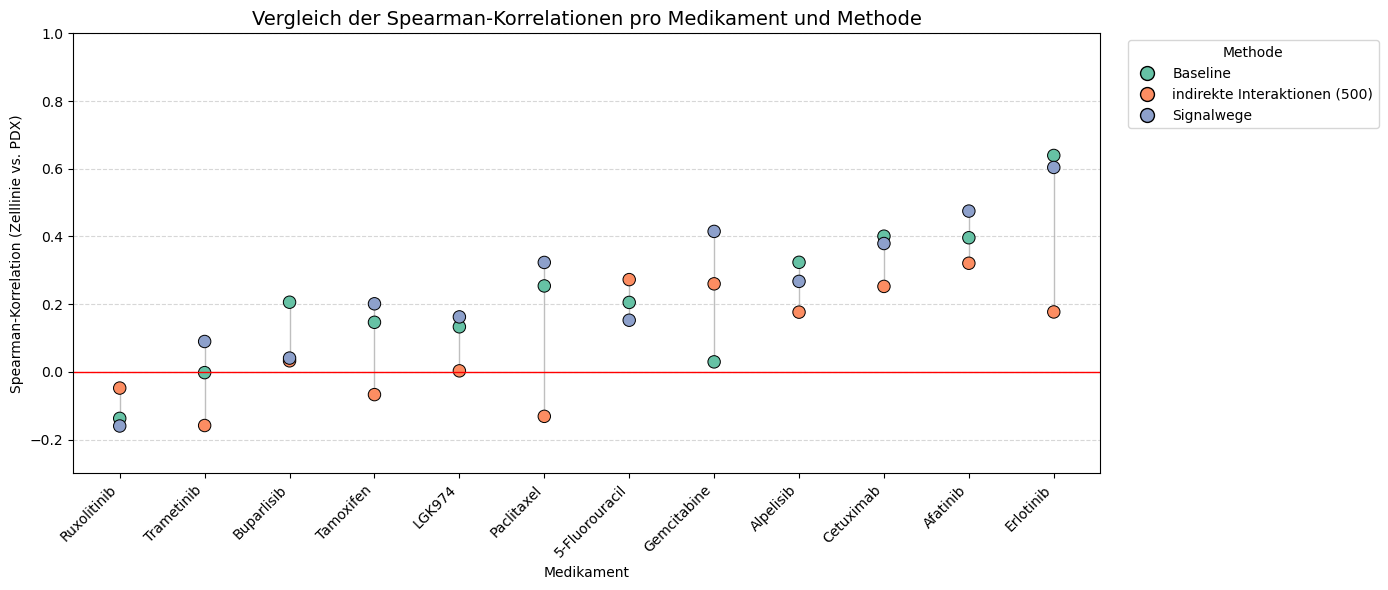

In [6]:
file_paths = {
    'Baseline': './results/DA/preds_AUC.csv',
    'indirekte Interaktionen (500)': './results/DA/preds_AUC_indirect_05.csv',
    'Signalwege': './results/DA/preds_AUC_naiv_pathway_level.csv',

}
spearman_pdx_vs_models_plot('./data/PDX_MTL_DA.csv', file_paths)


# Figure ...

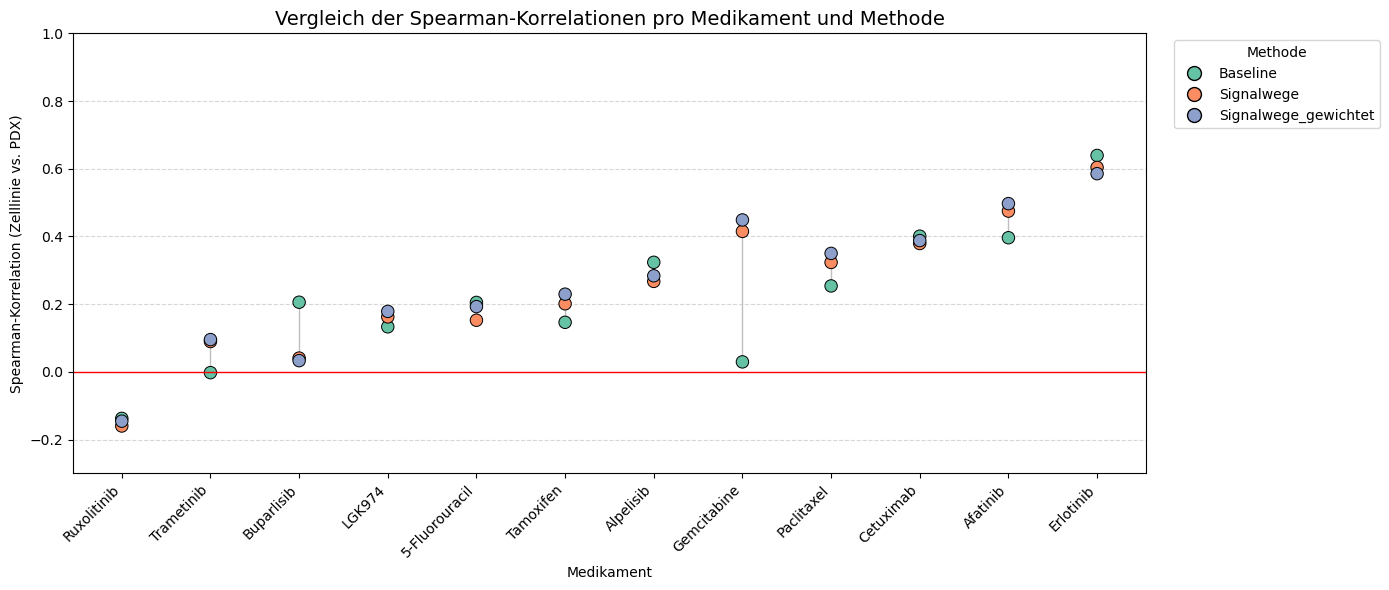

In [5]:
file_paths = {
    'Baseline': './results/DA/preds_AUC.csv',
    'Signalwege': './results/DA/preds_AUC_naiv_pathway_level.csv',
    'Signalwege_gewichtet': './results/DA/preds_AUC_pathway_weights_zscore.csv',
}
spearman_pdx_vs_models_plot('./data/PDX_MTL_DA.csv', file_paths)


# Figure ...

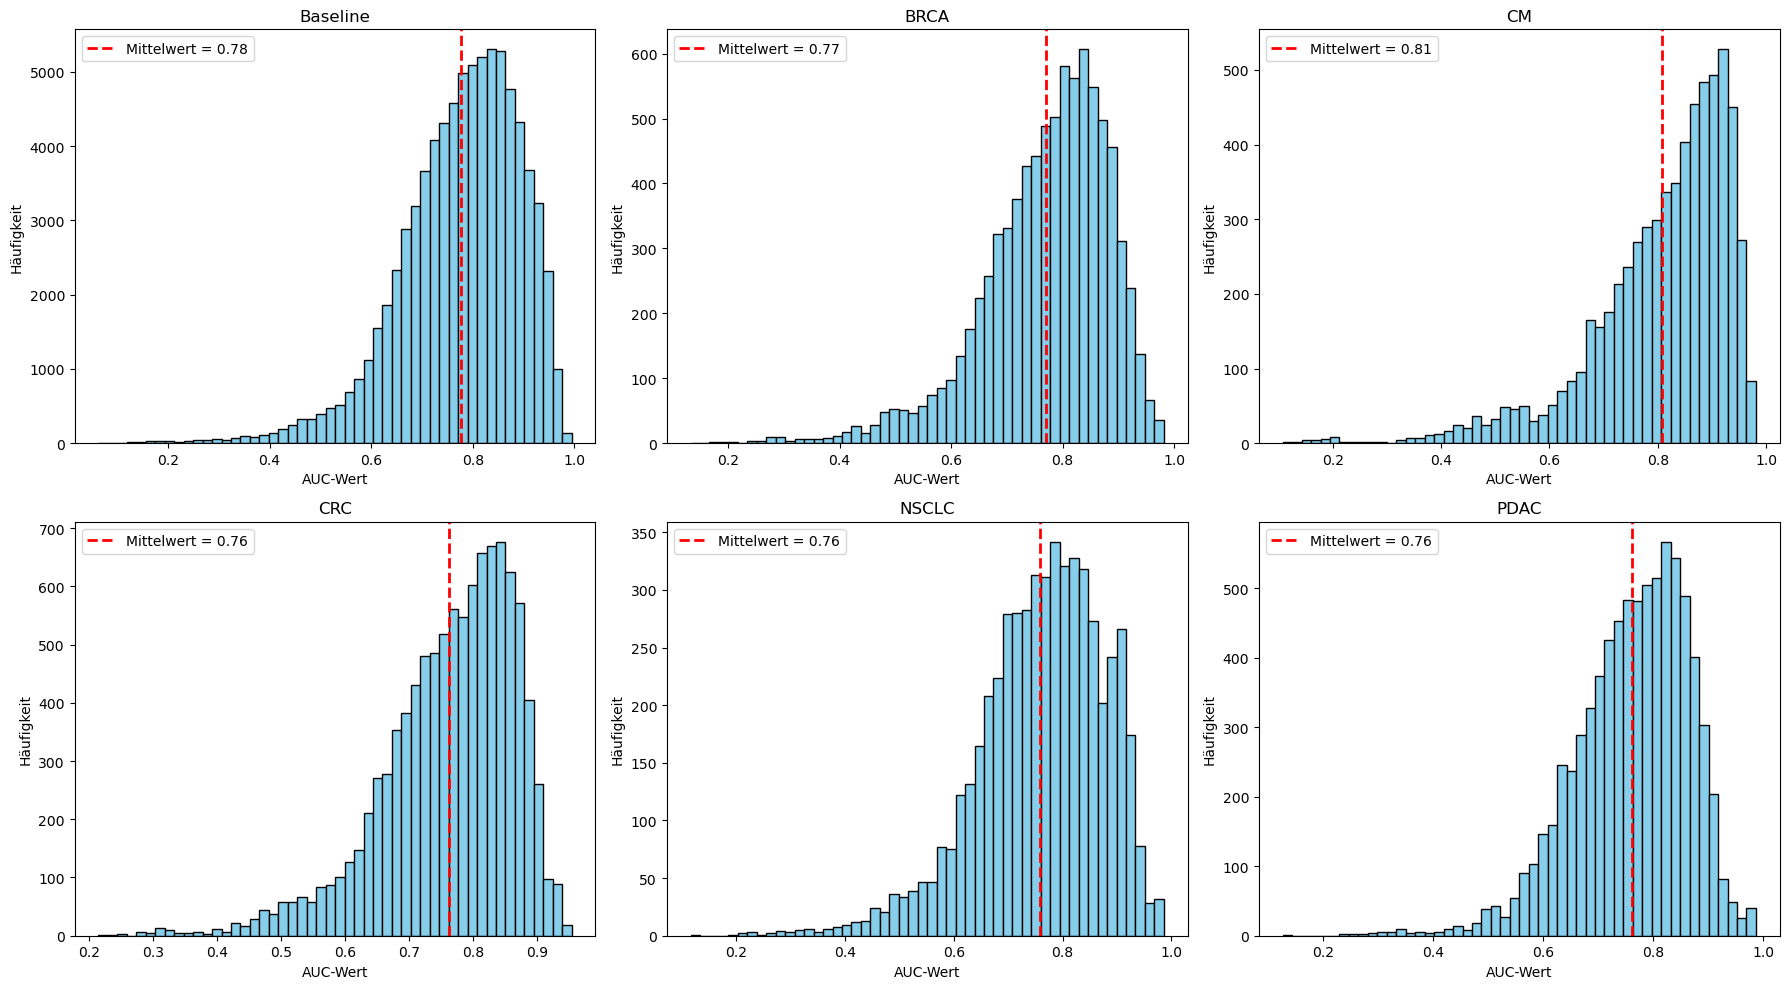

Baseline: 200 Punkte im Plot
BRCA: 200 Punkte im Plot
CM: 200 Punkte im Plot
CRC: 200 Punkte im Plot
NSCLC: 200 Punkte im Plot
PDAC: 200 Punkte im Plot


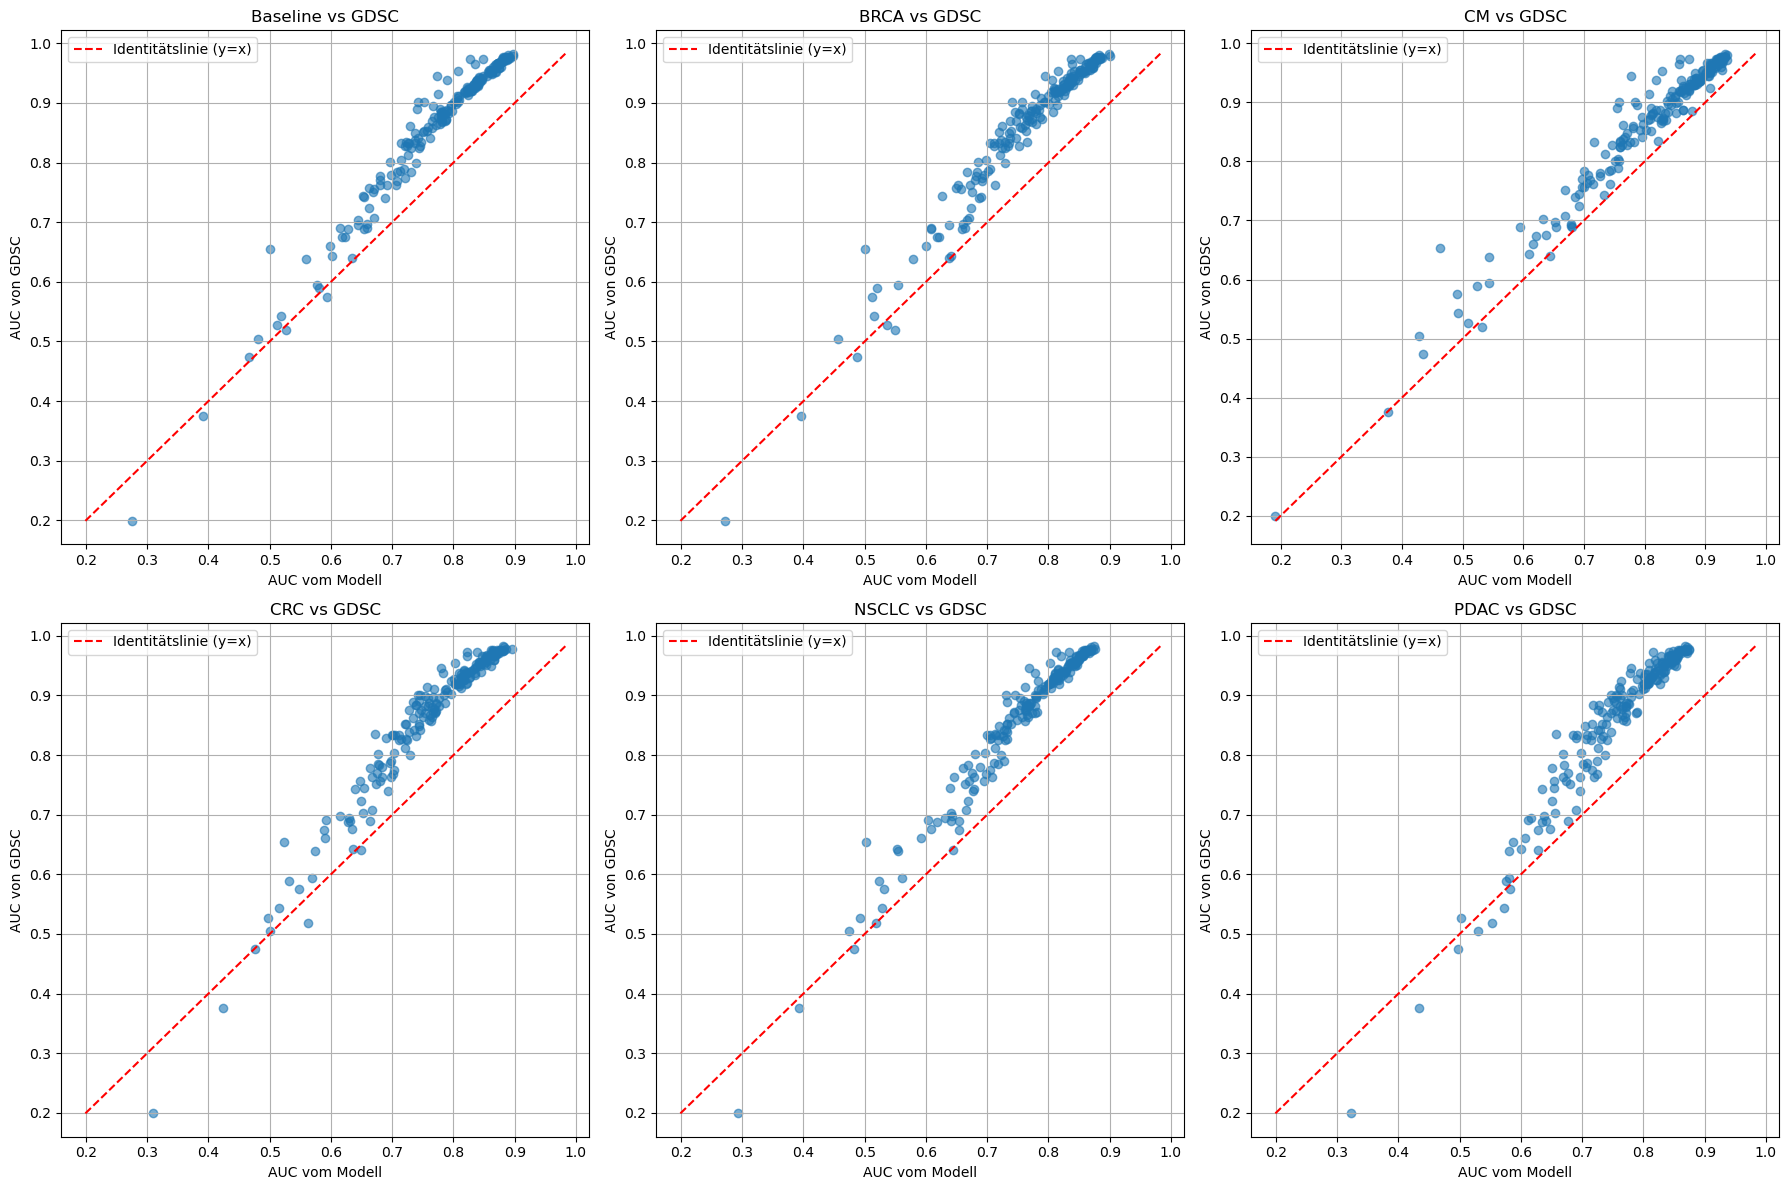

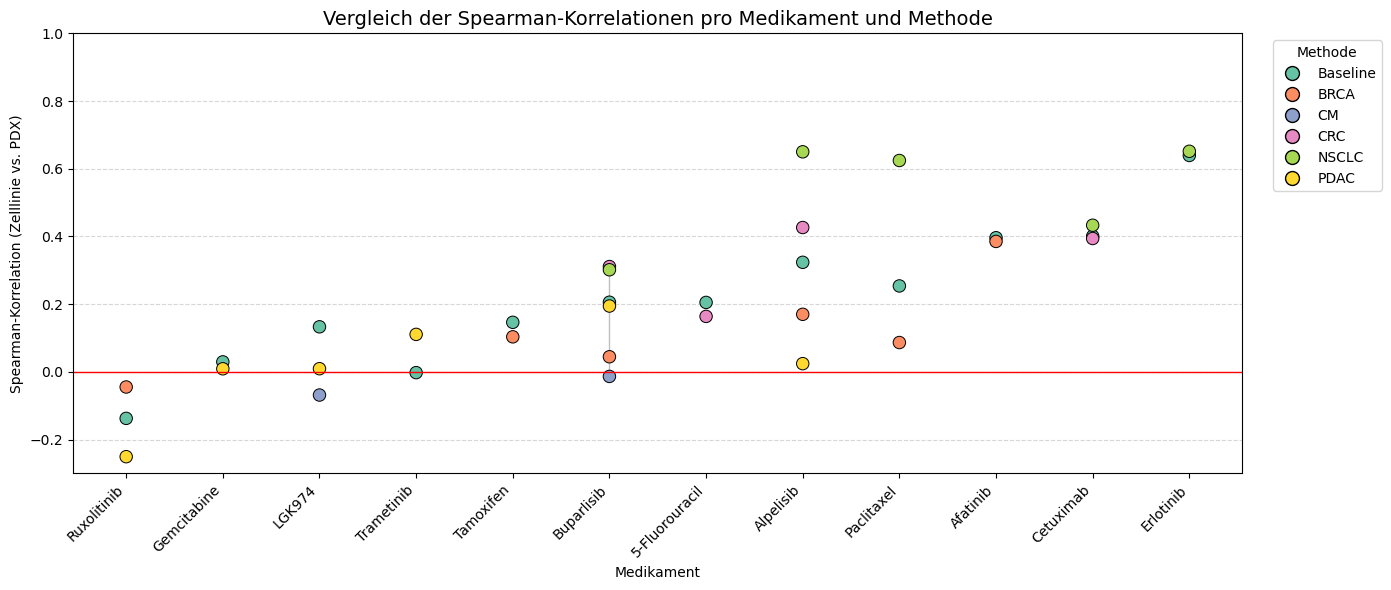

In [ ]:
file_paths = {
    'Baseline': './results/DA/preds_AUC.csv',
    'BRCA': './results/DA/preds_AUC_BRCA.csv',
    'CM': './results/DA/preds_AUC_CM.csv',
    'CRC': './results/DA/preds_AUC_CRC.csv',
    'NSCLC': './results/DA/preds_AUC_NSCLC.csv',
    'PDAC': './results/DA/preds_AUC_PDAC.csv'
    # 'NA': './results/DA/preds_AUC_NA.csv'
}
plot_auc_histograms(file_paths, bins=50, cols=3, figsize_per_row=5)
plot_model_vs_gdsc_scatter(file_paths, './data/GDSCDA_fpkm_AUC_all_drugs.zip')
spearman_pdx_vs_models_plot('./data/PDX_MTL_DA.csv', file_paths)

# UMG

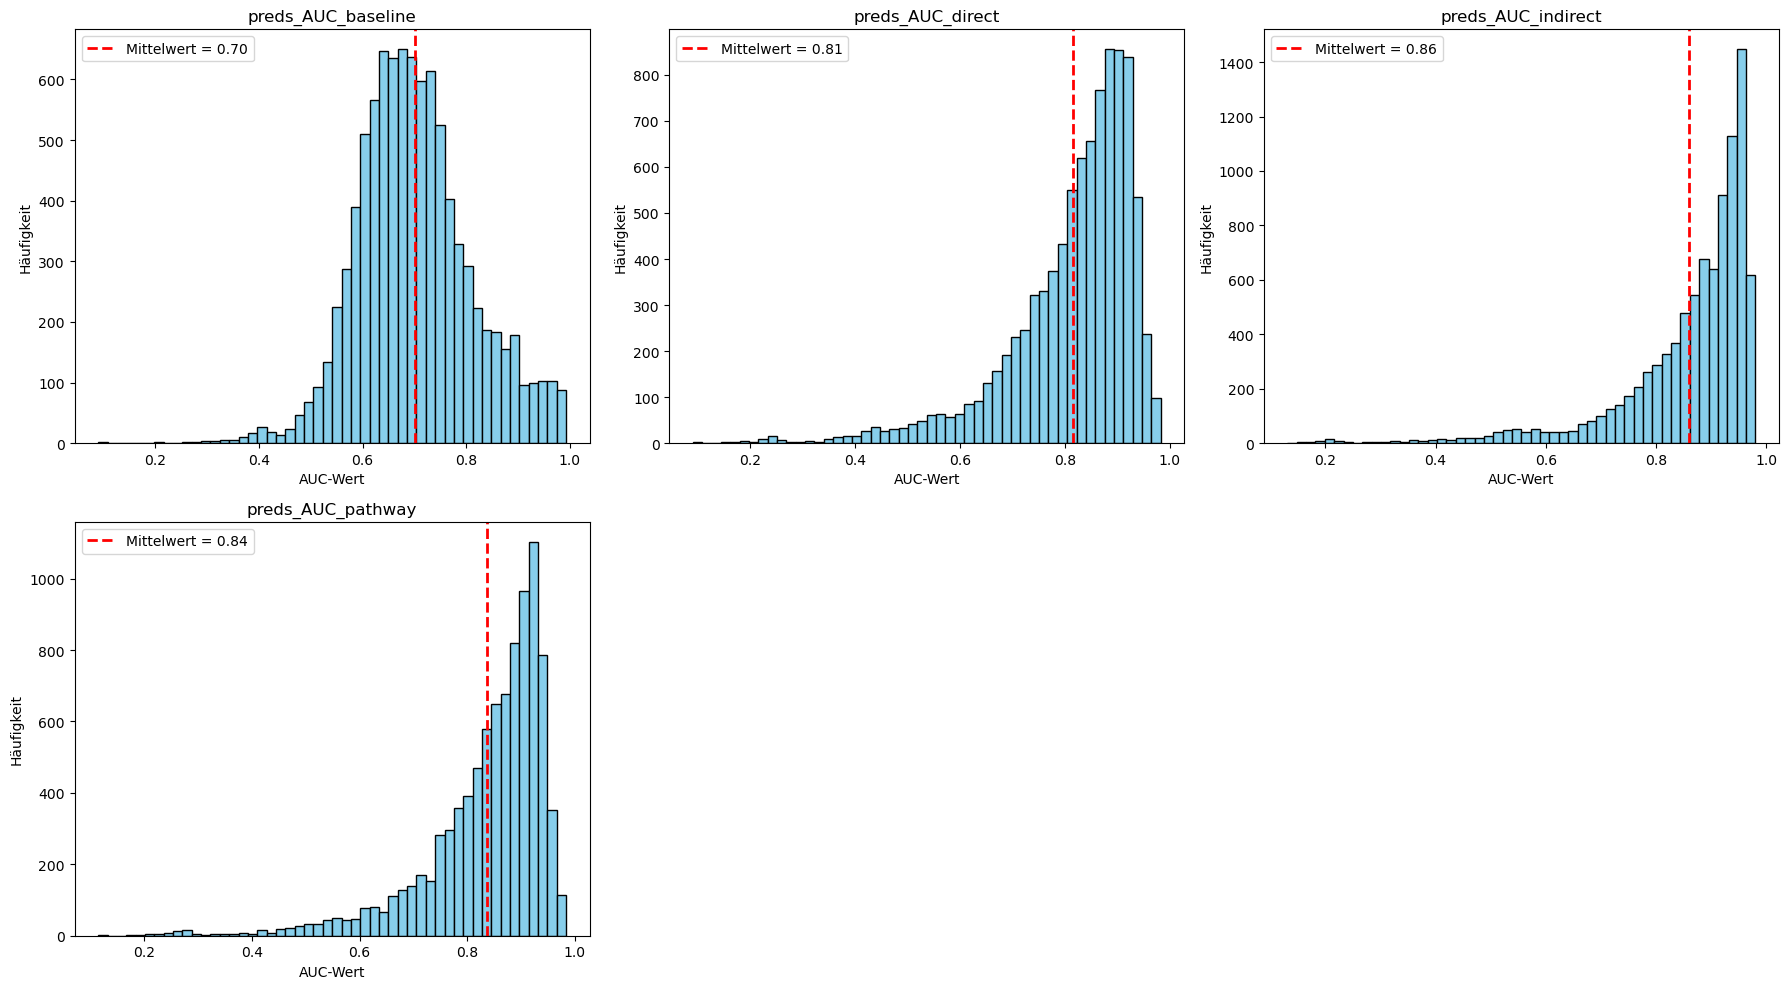

preds_AUC_baseline: 200 Punkte im Plot
preds_AUC_direct: 200 Punkte im Plot
preds_AUC_indirect: 200 Punkte im Plot
preds_AUC_pathway: 200 Punkte im Plot


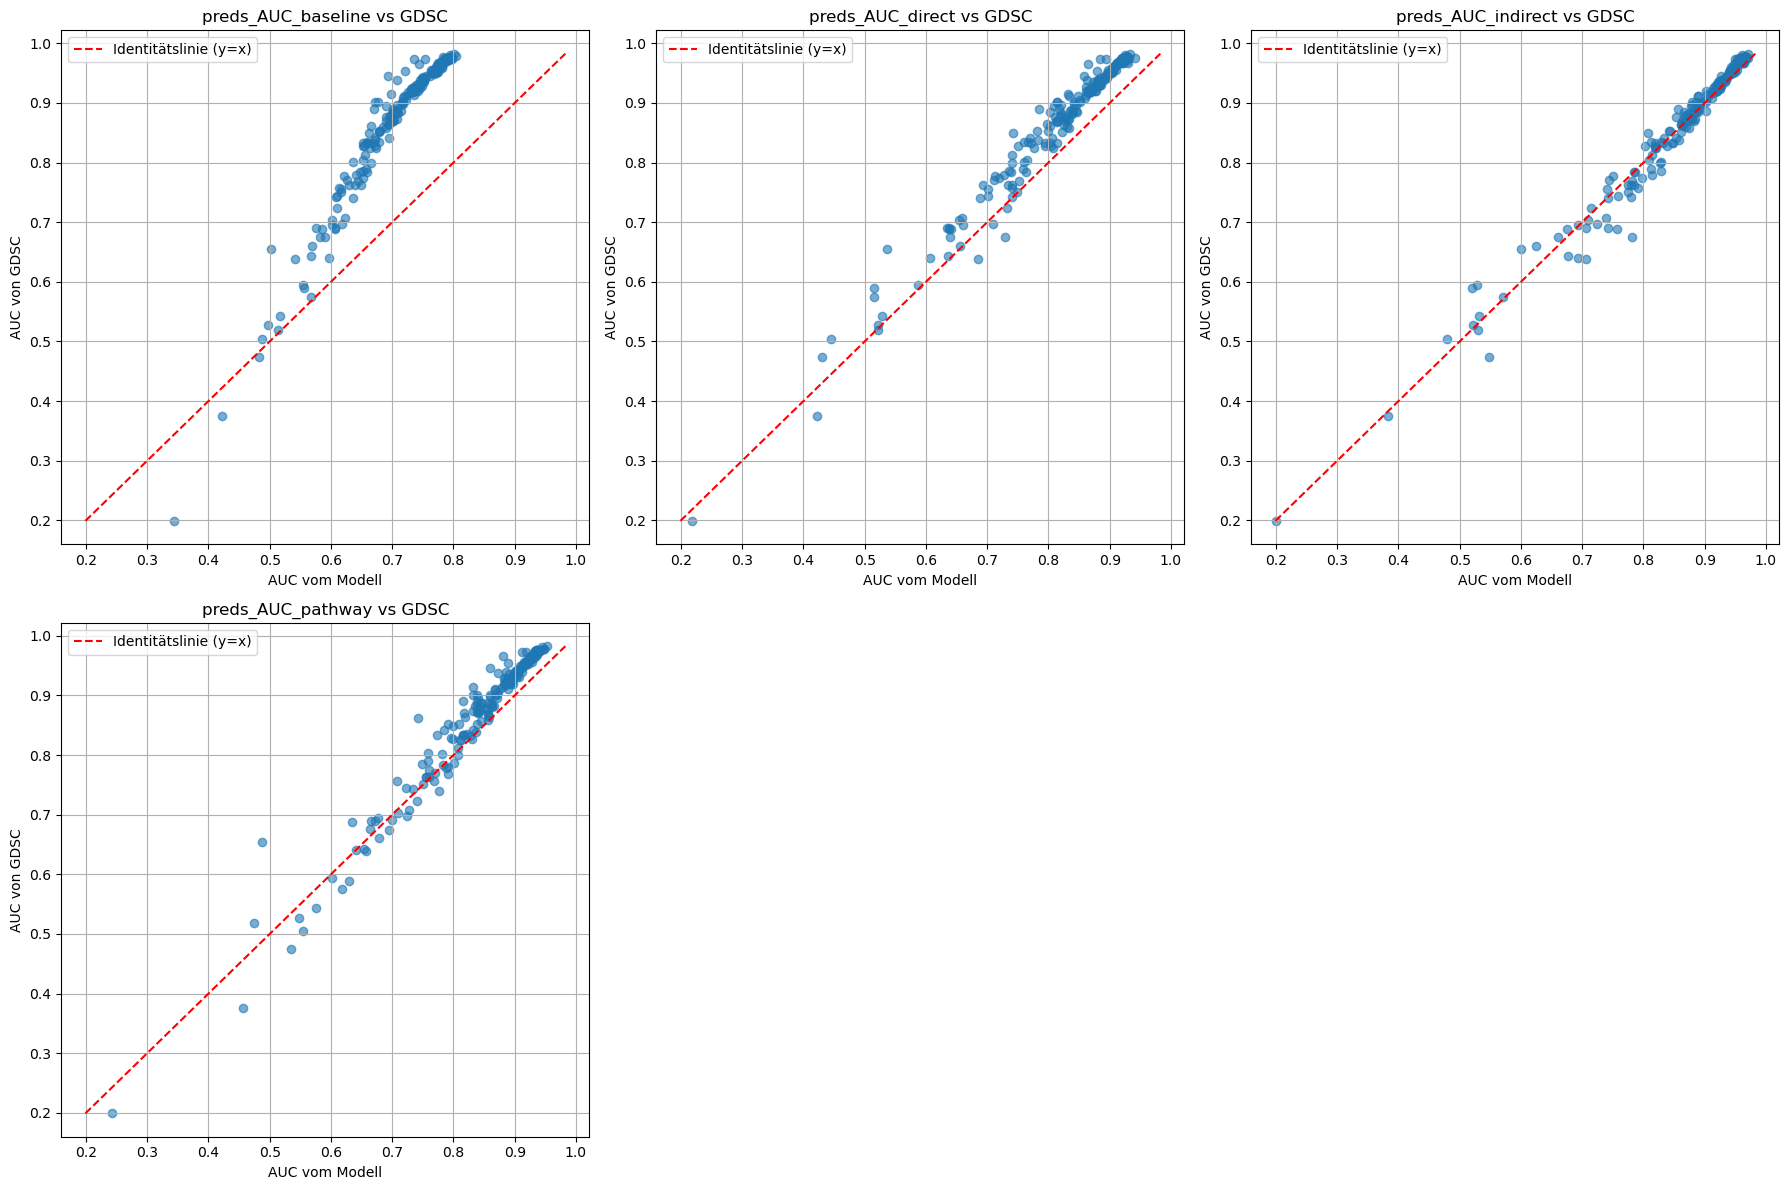

In [27]:
# Load each DataFrame with baseline and naive approach

file_paths = {
    'preds_AUC_baseline': './results/DA/UMG/preds_AUC_Goe.csv',
    'preds_AUC_direct': './results/DA/UMG/preds_AUC_direct_Goe.csv',
    'preds_AUC_indirect': './results/DA/UMG/preds_AUC_indirect_Goe.csv',
    'preds_AUC_pathway': './results/DA/UMG/preds_AUC_pathway_Goe.csv'

}

plot_auc_histograms(file_paths, bins=50, cols=3, figsize_per_row=5)
plot_model_vs_gdsc_scatter(file_paths, './data/GDSCDA_fpkm_AUC_all_drugs.zip')
